## 1. Intro

**Welcome to TransformerTorch 🚀**

✨ This notebook implemented **Transformer architecture** from the classic paper [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762)

✨ The implementation draws on the *Attention Is All You Need* paper, the PyTorch documentation, Aurélien Géron’s *Hands‑On Machine Learning* book, and [Wikipedia’s Transformer overview](https://en.wikipedia.org/wiki/Transformer_(deep_learning)).

✨ The design philosophy is **readability first**: the code is modular, follows PyTorch API conventions, and is structured for clarity.

✨ In the second part, a **Neural Machine Translation (NMT)** model is prepared and trained using Transformer architecture on **220k English–Spanish sentence pairs**, continuing from the earlier [RNN-Attention project](https://github.com/Hoom4n/AttentionNMT) with the same dataset. (with BPE tokenization, shared vocabulary across languages, shared embedding, and weight tying).

<center>
<br>
<img src="https://cdn-uploads.huggingface.co/production/uploads/65f42e30c9940817caaaa8e6/g4IyUviCFdcbVqe1Izijl.png" width="500">
</center>

Project GitHUB : [TransformerTorch](https://github.com/Hoom4n/TransformerTorch)

## 2. Implementing Transformer Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

### Positional Embedding

In [2]:
class PositionalEmbedding(nn.Module):
    """
    Positional Embedding
    
    shapes:
        N: batch size
        L: seq len (max seq len of batch)
        E: embedding dim
        max_seq_len: max seq len across all samples
    
    forward args:
        X: batch of semantic embeddings (N, L, E)
    """
    def __init__(self, emb_dim, max_seq_len, dropout_p=0.1):
        super().__init__()
        
        # full embedding matrix with shape (maximum_sample_lenght, embedding_dim)
        self.pos_embedding = nn.Parameter(torch.randn(max_seq_len, emb_dim) * 0.01)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, X):
        
        # sliced for current batch max sequence lenght
        emb_matrix = self.pos_embedding[:X.size(1)].unsqueeze(0)  # (1, L, E)         
        return self.dropout(X + emb_matrix) # (N, L, E) 

### Scaled Dot Product Attention

<center>$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^{\top}}{\sqrt{d_k}}\right) V$</center>

In [3]:
class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot Product Attention
    
    shapes:
        N: batch size
        H: num of heads
        Lq: query seq len (source)
        Lk: key seq len (target)
        E: per-head embedding dim (for query/key)
    
    forward args:
        query: (N, H, Lq, E)
        key: (N, H, Lk, E)
        value: (N, H, Lk, Ev)
        attn_mask: optional bool/float mask, broadcastable to (N, H, Lq, Lk). True/-inf = ignore, False/0 = attend
        key_padding_mask: optional bool mask (N, Lk), marks padding tokens to ignore

    returns:
        output: (N, H, Lq, Ev)
    """
    def __init__(self, dropout_p=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        assert query.size(-1) == key.size(-1) # E
        assert key.size(-2) == value.size(-2) # Lk

        # scaled by 1 / sqrt(d_k)
        scale_factor = 1 / (key.size(-1) ** 0.5)

        attn_weights = query @ key.transpose(-2, -1) * scale_factor # (N, H, Lq, Lk)    
        # torch internally aggregates all masks into an attention bias
        # and applies them to the attention weights in one step. 

        # general purpose mask
        if attn_mask is not None:
            attn_weights = attn_weights.masked_fill(attn_mask, float("-inf")) 

        # masking padding tokens
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2) # (N, 1, 1, Lk)
            attn_weights = attn_weights.masked_fill(key_padding_mask, float("-inf"))
            
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)
        return attn_weights @ value # (N, H, Lq, d)

### Multi Head Attention

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Multi Head Attention
    
    shapes:
        N: batch size
        E: total model dimension (emb_dim)
        H: number of heads
        d: per-head dimension = E // H
        Lq: query seq len
        Lk: key seq len
    
    forward args:
        query: (N, Lq, E)
        key:   (N, Lk, E)
        value: (N, Lk, Ev)
        attn_mask: optional bool mask, broadcastable to (N, H, Lq, Lk). True = ignore, False = attend
        key_padding_mask: optional bool mask (N, Lk), marks padding tokens to ignore
    
    returns:
        output: (N, Lq, E)
    """
    def __init__(self, emb_dim, num_heads, dropout_p=0.0):
        super().__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.per_head_dim = int(emb_dim // num_heads)
        self.scaled_dot_product_attention = ScaledDotProductAttention(dropout_p = dropout_p)
        
        self.q_proj = nn.Linear(emb_dim, emb_dim)
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.out_proj = nn.Linear(emb_dim, emb_dim)

    def _split_heads(self, X):
        # split tensors into heads, along E embedding dim
        return X.reshape(X.size(0), X.size(1), self.num_heads, self.per_head_dim).transpose(1,2) # (N, H, L, d)

    def forward(self, query, key, value,
                key_padding_mask=None, attn_mask=None):
        
        q = self._split_heads(self.q_proj(query)) # (N, H, Lq, d)
        k = self._split_heads(self.k_proj(key)) # (N, H, Lk, d)
        v = self._split_heads(self.v_proj(value)) # (N, H, Lk, d)

        Z = self.scaled_dot_product_attention(q, k, v,
                                              attn_mask = attn_mask,
                                              key_padding_mask = key_padding_mask) # (N, H, Lq, d)
        Z = Z.transpose(1,2) # (N, Lq, H, d)
        
        # concatnate along heads
        Z = Z.reshape(Z.size(0), Z.size(1), self.num_heads * self.per_head_dim) # (N, Lq, H * d) or (N, Lq, E)
        return self.out_proj(Z) # (N, Lq, E)

### Encoder Layer

In [5]:
class TransformerEncoderLayer(nn.Module):
    """
    Transformer Encoder Layer

    shapes:
        N: batch size
        S: (source) sequence length
        E: model dimension (d_model)
        H: number of heads

    args:
        d_model: total model dimension (E)
        nhead: number of attention heads (H)
        dim_feedforward: hidden dimension of ffn
    
    forward args:
        src: (N, S, E)
        src_mask: optional bool/float mask, broadcastable to (N, H, S, S)
        src_key_padding_mask: optional bool mask (N, S), marks padding tokens to ignore

    returns:
        output: (N, S, E), encoded sequence representation
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout_p=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
    
        self.self_attention_mha = MultiHeadAttention(emb_dim = d_model,
                                                     num_heads = nhead,
                                                     dropout_p = dropout_p)
        
        self.ffn = nn.Sequential(
            # reverse bottleneck
            nn.Linear(d_model, dim_feedforward), 
            nn.ReLU(), # GELU is more common in newer models
            nn.Dropout(dropout_p),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout_p)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
       
        # self attention
        attn = self.self_attention_mha(src, src, src,
                        attn_mask = src_mask, 
                        key_padding_mask = src_key_padding_mask)
        
        # first add & norm + residual
        Z = self.norm1(attn + src) 
        
        # feed forward network + residual + second add & norm
        return self.norm2(Z + self.ffn(Z)) 

### Decoder Layer

In [6]:
class TransformerDecoderLayer(nn.Module):
    """
    Transformer Decoder Layer

    shapes:
        N: batch size
        L: target sequence length
        S: source sequence length
        E: model dimension (d_model)
        H: number of heads

    args:
        d_model: total model dimension (E)
        nhead: number of attention heads (H)
        dim_feedforward: hidden dimension of ffn

    forward args:
        tgt: (N, L, E), target sequence embeddings
        memory: (N, S, E), encoder output
        tgt_mask: optional bool/float mask, broadcastable to (N, H, L, L),
        memory_mask: optional bool/float mask, broadcastable to (N, H, L, S),
        tgt_key_padding_mask: optional bool mask (N, L)
        memory_key_padding_mask: optional bool mask (N, S)

    returns:
        output: (N, L, E), decoded target sequence representation
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout_p=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
    
        self.self_attention_mha = MultiHeadAttention(emb_dim = d_model,
                                                     num_heads = nhead, dropout_p = dropout_p)
        self.cross_attention_mha = MultiHeadAttention(emb_dim = d_model,
                                                      num_heads = nhead, dropout_p = dropout_p)
        
        self.ffn = nn.Sequential(
            # reverse bottleneck
            nn.Linear(d_model, dim_feedforward), 
            nn.ReLU(), # GELU is more common in newer models
            nn.Dropout(dropout_p),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout_p)
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, tgt, memory,
                tgt_mask = None, memory_mask = None,
                tgt_key_padding_mask = None,
                memory_key_padding_mask = None):
        
        # masked self attention 
        self_attn_output = self.self_attention_mha(tgt, tgt, tgt,
                                                   attn_mask = tgt_mask,
                                                   key_padding_mask = tgt_key_padding_mask)
        
        # first add & norm + residual
        Z = self.norm1(tgt + self.dropout(self_attn_output))

        # cross-attention: query = enriched target, key/value = encoder outputs
        cross_attn_output = self.cross_attention_mha(query = Z, key = memory, value = memory,
                                                     attn_mask = memory_mask, 
                                                     key_padding_mask = memory_key_padding_mask)
        
        # second add & norm + residual
        Z = self.norm2(Z + self.dropout(cross_attn_output))

        # feedforward network + residual + third add & norm
        return self.norm3(Z + self.ffn(Z))

### Transformer Encoder

In [7]:
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder

    args:
        encoder_layer: instance of TransformerEncoderLayer
        num_layers: num of encoder layers to stack

    forward args:
        src: (N, S, E), source sequence embeddings
        mask: optional bool/float mask, broadcastable to (N, H, S, S)
        src_key_padding_mask: optional bool mask (N, S)

    returns:
        output: (N, S, E), encoded source sequence representation
    """
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        
        # create fresh copies of the encoder layer
        self.layers = nn.ModuleList([deepcopy(encoder_layer) for _ in range(num_layers)])
        
    def forward(self, src, mask=None, src_key_padding_mask=None):
        Z = src
        
        for mod in self.layers:
            Z = mod(src = Z,
                    src_mask = mask,
                    src_key_padding_mask = src_key_padding_mask)
        
        # torch adds an optional final LayerNorm here, but the og paper doesn't
        return Z

### Transformer Decoder

In [8]:
class TransformerDecoder(nn.Module):
    """
    Transformer Decoder

    args:
        encoder_layer: instance of TransformerDecoderLayer
        num_layers: num of encoder layers to stack 

    forward args:
        tgt: (N, L, E), target sequence embeddings
        memory: (N, S, E), encoder output 
        tgt_mask: optional bool/float mask, broadcastable to (N, H, L, L)
        memory_mask: optional bool/float mask, broadcastable to (N, H, L, S)
        tgt_key_padding_mask: optional bool mask (N, L)
        memory_key_padding_mask: optional bool mask (N, S)

    returns:
        output: (N, L, E), decoded target sequence representation
    """
    def __init__(self, decoder_layer, num_layers):
        super().__init__()

        # create fresh copies of the decoder layer
        self.layers = nn.ModuleList([deepcopy(decoder_layer) for _ in range(num_layers)])

    def forward(self, tgt, memory, tgt_mask=None,
                memory_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):
        Z = tgt

        # each layer takes the same encoder output (memory) and the updated target sequence (Z)
        for mod in self.layers:
            Z = mod(tgt = Z, memory = memory, tgt_mask=tgt_mask,
                    memory_mask = memory_mask,
                    tgt_key_padding_mask = tgt_key_padding_mask,
                    memory_key_padding_mask = memory_key_padding_mask)
        
        # torch adds an optional final LayerNorm here, but the og paper doesn't
        return Z   

### Transformer

In [9]:
class Transformer(nn.Module):
    """
    Full Transformer (Encoder + Decoder)

    args:
        d_model: toatal model dimension (default=512)
        nhead: num of attention heads
        num_encoder_layers: num of encoder layers
        num_decoder_layers: num of decoder layers
        dim_feedforward: hidden dimension of ffn (default=2048)
        dropout_p: dropout prob (default=0.1)

    forward args:
        src: (N, S, E), source sequence embeddings
        tgt: (N, L, E), target sequence embeddings
        src_mask: optional bool/float mask, broadcastable to (N, H, S, S)
        tgt_mask: optional bool/float mask, broadcastable to (N, H, L, L)
        memory_mask: optional bool/float mask, broadcastable to (N, H, L, S)
        src_key_padding_mask: optional bool mask (N, S)
        tgt_key_padding_mask: optional bool mask (N, L)
        memory_key_padding_mask: optional bool mask (N, S)

    returns:
        output: (N, L, E), decoded target sequence representation
    """

    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout_p=0.1):
        super().__init__()
        
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout_p)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout_p)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers)

    def forward(self, src, tgt,
                src_mask=None, tgt_mask=None, memory_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):
      
        memory = self.encoder(src=src, mask=src_mask,
                              src_key_padding_mask=src_key_padding_mask)  
        
        return self.decoder(tgt = tgt, memory = memory,
                            tgt_mask = tgt_mask, memory_mask = memory_mask,
                            tgt_key_padding_mask = tgt_key_padding_mask, 
                            memory_key_padding_mask = memory_key_padding_mask)

## 3. Neural Machine Translation with Transformer

### Configuration

In [10]:
import os, re, importlib, unicodedata, json
from itertools import chain

import pandas as pd
import tokenizers
from torchmetrics import Accuracy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

pd.set_option("max_colwidth", 500)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch Device: {device}")

Torch Device: cuda


In [11]:
def create_project_dirs(root_dir: str,
                        dirs: list = ["data", "artifacts", "model", "tokenizer"]) -> list:
    """Create project directories and return their paths."""
    path_list = [os.path.join(root_dir, dir_) for dir_ in dirs]
    for p in path_list:
        os.makedirs(p, exist_ok=True)
    return path_list

ROOT_DIR = os.getcwd()
DATA_PATH, ARTIFACTS_PATH, MODEL_PATH, TOKENIZER_PATH = create_project_dirs(ROOT_DIR)

In [12]:
%%writefile src/config.py
from dataclasses import dataclass, field

@dataclass
class HPARAMS:
    vocab_size = 12500
    max_seq_len = 32
    batch_size = 128

    model_hparams: dict = field(default_factory=lambda: {
    "d_model" : 512,
    "nhead" : 8,
    "num_encoder_layers" : 2,
    "num_decoder_layers" : 2,
    "dim_feedforward" : 2048,
    "dropout" : 0.1,
    "padding_idx" : 0,
    })
    
    optimizer_hparams: dict = field(default_factory=lambda: {
        "lr": 1e-3,
        "weight_decay": 2e-5
    })


    trainer_hparams: dict = field(default_factory=lambda: {
    "n_epochs": 20,
    "enable_mixed_precision": True,
    "restore_best_model" : False,
    "use_early_stopping" : True,
    "early_stopping_patience" : 3,
    "grad_clip_value" : None
    })

Overwriting src/config.py


In [13]:
import src.config
importlib.reload(src.config)
from src.config import HPARAMS
hp = HPARAMS()

### Data Preparation

In [14]:
def quick_eda(data_path):
    df = pd.read_parquet(data_path)
    print(f"*** dataset size: {df.shape[0]:,} ***")
    print(f"*** nan count: {df.isna().sum().sum()} ***")
    print("*** word count describe: ***")
    print(pd.concat([df[col].str.split().str.len().describe() for col in df.columns], axis=1))
    print(f"*** uniques characters: ***\n{sorted(set("".join(chain(df.target_text , df.source_text))))}")
    return df.head(5)

quick_eda(os.path.join(DATA_PATH, "eng_spa.parquet"))

*** dataset size: 221,813 ***
*** nan count: 0 ***
*** word count describe: ***
         source_text    target_text
count  221813.000000  221813.000000
mean        6.917854       6.729673
std         4.070935       9.192844
min         1.000000       1.000000
25%         5.000000       4.000000
50%         6.000000       6.000000
75%         8.000000       8.000000
max       214.000000    3823.000000
*** uniques characters: ***
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¨', 'ª', '«', '\xad', '°', '³', '´', 'º', '»', '¿', 'À', 'Á', 'Â', 'Ã', 'Ç', 'É', 'Í', 'Ñ', 'Ó', 'Ú', 'Ü', 'ß', 'à

,source_text,target_text
0,My hobby is to listen to music.,Mi afición es escuchar música.
1,It suddenly started raining.,De repente se puso a llover.
2,Hurry.,Apresúrese.
3,Do tell!,¡Dígalo!
4,"Could you repeat that, please?","¿Podrías repetirlo, por favor?"


In [15]:
def get_data(data_path, val_frac = 0.15):
    df = pd.read_parquet(data_path)\
        .sample(frac=1.0, random_state=42)\
        .reset_index(drop=True)
    
    split = int(len(df) * val_frac)
    val, train = df.iloc[:split], df.iloc[split:]
    print(f"*** train size: {len(train):,} | val size: {len(val):,} ***")
    return train, val

train, val = get_data(os.path.join(DATA_PATH, "eng_spa.parquet"))

*** train size: 188,542 | val size: 33,271 ***


### Training BPE Tokenizer

In [16]:
def bpe_trainer(
    train_iterator,
    vocab_size,
    save_path,
    special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"],
    enable_truncation = True,
    max_seq_len = 128,
    enable_padding = True,
    allowed_chars = r"[^a-z0-9áéíóúüñ¿¡\.\,\!\?\:\;\"\'\-\(\)\s]",
    sample_demo_text = "[BOS] I love Deep Learning!!! [EOS]"
):
    """
    Train and save a Byte-Pair Encoding (BPE) tokenizer.

    This function builds a subword tokenizer from a text iterator (e.g., training corpus),
    applies Unicode normalization, lowercasing, and character filtering, then trains a joint
    vocabulary for both source and target languages (ideal for bilingual NMT setups).
    It also configures truncation, padding, and outputs a sample encoding preview.
    """
    tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
    
    tokenizer.normalizer = tokenizers.normalizers.Sequence([
            tokenizers.normalizers.NFKC(), # unicode normalization
            tokenizers.normalizers.Lowercase(),
            tokenizers.normalizers.Replace(tokenizers.Regex(allowed_chars), ""), # keep only valid en-es charchters
            tokenizers.normalizers.Replace(tokenizers.Regex(r"\s+"), " "), # collapse runs of spaces
        ])

    trainer = tokenizers.trainers.BpeTrainer(
        vocab_size = vocab_size,
        special_tokens=special_tokens,
        show_progress = False
    )
    tokenizer.train_from_iterator(train_iterator, trainer)
    print(f"*** vocab size: {tokenizer.get_vocab_size():,} ***")

    if enable_truncation:
        tokenizer.enable_truncation(max_seq_len)
        print(f"*** tokenizer truncated to max len: {max_seq_len} ***")

    if enable_padding:
        tokenizer.enable_padding(pad_token="[PAD]", pad_id=0)

    if sample_demo_text is not None:
        enc = tokenizer.encode(sample_demo_text)
        print(f"\nSample demo text: {sample_demo_text}")
        print(f"Tokens: {enc.tokens}")
        print(f"Token IDs: {enc.ids}")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    tokenizer.save(save_path)
    print(f"\n*** trained tokenizer saved to: {save_path} ***")

bpe_trainer(chain(train.source_text, train.target_text),
            hp.vocab_size,
            os.path.join(TOKENIZER_PATH,"bpe_tokenizer.json"),
            max_seq_len=hp.max_seq_len)

*** vocab size: 12,500 ***
*** tokenizer truncated to max len: 32 ***

Sample demo text: [BOS] I love Deep Learning!!! [EOS]
Tokens: ['[BOS]', 'i', 'love', 'deep', 'learning', '!', '!', '!', '[EOS]']
Token IDs: [2, 33, 564, 3057, 2677, 4, 4, 4, 3]

*** trained tokenizer saved to: /mnt/c/Users/ASUS/Documents/Machine-Learning/GitHUB/TransformerTorch/tokenizer/bpe_tokenizer.json ***


### Dataset & Collate Func

In [17]:
class NMTDataset(Dataset):
    """Custom Dataset for paired source–target text sequences."""
    def __init__(self, src_iterator, tgt_iterator):
        assert len(src_iterator) == len(tgt_iterator), "src and target must have same size"
        self.src_iterator = src_iterator
        self.tgt_iterator = tgt_iterator

        if isinstance(self.src_iterator, pd.Series):
            self.src_iterator = self.src_iterator.reset_index(drop=True)
        if isinstance(self.tgt_iterator, pd.Series):
            self.tgt_iterator = self.tgt_iterator.reset_index(drop=True)
        
    def __len__(self):
        return len(self.src_iterator)

    def __getitem__(self, idx):
        return (self.src_iterator[idx] , self.tgt_iterator[idx])

In [18]:
def collate_fn(batch, pad_token_id = 0):
    src_list, tgt_list = zip(*batch)
    tgt_list = [f"[BOS] {s} [EOS]" for s in tgt_list]
    
    src_ids = torch.tensor([enc.ids for enc in tokenizer.encode_batch(src_list)], dtype=torch.long)
    tgt_ids = torch.tensor([enc.ids for enc in tokenizer.encode_batch(tgt_list)], dtype=torch.long)

    src_key_padding_mask = (src_ids == pad_token_id)
    tgt_key_padding_mask = (tgt_ids == pad_token_id)
    
    labels = tgt_ids[:, 1:].clone()
    # assign -100 to padding steps, making them invisible to the loss computation
    labels[labels == pad_token_id] = -100
    
    return ({
        "src_ids": src_ids, 
        "src_key_padding_mask": src_key_padding_mask, 
        "tgt_ids": tgt_ids[:, :-1], 
        "tgt_key_padding_mask": tgt_key_padding_mask[:, :-1]
            }, labels)

### Model

I will use PyTorch’s `nn.Transformer` module, which is functionally equivalent to my custom `Transformer`, but include CUDA optimizations and fused ops that make training faster.

In [19]:
%%writefile src/model.py
import torch
import torch.nn as nn

class PositionalEmbedding(nn.Module):
    """
    Positional Embedding
    
    shapes:
        N: batch size
        L: seq len (max seq len of batch)
        E: embedding dim
        max_seq_len: max seq len across all samples
    
    forward args:
        X: batch of semantic embeddings (N, L, E)
    """
    def __init__(self, emb_dim, max_seq_len, dropout_p=0.1):
        super().__init__()
        
        # full embedding matrix with shape (maximum_sample_lenght, embedding_dim)
        self.pos_embedding = nn.Parameter(torch.randn(max_seq_len, emb_dim) * 0.01)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, X):
        
        # sliced for current batch max sequence lenght
        emb_matrix = self.pos_embedding[:X.size(1)].unsqueeze(0)  # (1, L, E)         
        return self.dropout(X + emb_matrix) # (N, L, E) 

Overwriting src/model.py


In [20]:
%%writefile -a src/model.py
class TransformerNMT(nn.Module):
    """
    forward args:
        src_ids: (N, S) token ids
        tgt_ids: (N, L) token ids
        src_key_padding_mask: (N, S) bool, True=PAD (ignored)
        tgt_key_padding_mask: (N, L) bool, True=PAD (ignored)
    """
    def __init__(self, vocab_size, max_seq_len, d_model=512, nhead=4,
                 num_encoder_layers=2, num_decoder_layers=2,
                 dim_feedforward=2048, dropout=0.1, padding_idx=0):
        super().__init__()

        self.shared_embedding = nn.Embedding(vocab_size, d_model, padding_idx = padding_idx)
        self.positional_embedding = PositionalEmbedding(d_model, max_seq_len)
        
        self.transformer = nn.Transformer(d_model, nhead,
                                          num_encoder_layers, num_decoder_layers,
                                          dim_feedforward, dropout,
                                          activation="relu", batch_first=True, 
                                          norm_first=False, bias=True)
        
        self.output = nn.Linear(d_model, vocab_size, bias=False)
        
        # weight tying
        self.output.weight = self.shared_embedding.weight

    def forward(self, src_ids, tgt_ids, src_key_padding_mask, tgt_key_padding_mask):

        src = self.positional_embedding(self.shared_embedding(src_ids)) # (N, S, E)
        tgt = self.positional_embedding(self.shared_embedding(tgt_ids)) # (N, L, E)

        # create target causal mask
        L = tgt.size(1)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(L, dtype = torch.bool, device = tgt.device)
        
        out = self.transformer(src = src , tgt = tgt,
                               src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask = tgt_key_padding_mask,
                               memory_key_padding_mask = src_key_padding_mask,
                               tgt_mask = causal_mask
                              ) # (N, L, E)

        return self.output(out).transpose(-2,-1) # (N, vocab_size, L)

Appending to src/model.py


### Training

In [21]:
from src.model import TransformerNMT
from src.trainer import trainer, save_training_artifacts

torch.manual_seed(42)

# PREPARE TOKENIZER 
tokenizer = tokenizers.Tokenizer.from_file(os.path.join(TOKENIZER_PATH, "bpe_tokenizer.json"))
vocab_size = tokenizer.get_vocab_size()

# PREPARE DATALOADER
train_ds = NMTDataset(train.source_text, train.target_text)
val_ds = NMTDataset(val.source_text, val.target_text)

train_loader = DataLoader(train_ds, batch_size=hp.batch_size,
                          collate_fn = collate_fn, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=hp.batch_size,
                        collate_fn = collate_fn, pin_memory=True, shuffle=False)

# TRAINING
model = TransformerNMT(vocab_size, hp.max_seq_len, **hp.model_hparams).to(device)

optimizer = torch.optim.NAdam(model.parameters(), **hp.optimizer_hparams)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
metric = Accuracy(task="multiclass", num_classes = vocab_size, ignore_index= -100).to(device)

train_logs = trainer(model=model, optimizer=optimizer,
                     loss_fn=loss_fn, metric=metric,
                     device=device, train_loader=train_loader,
                     val_loader=val_loader, **hp.trainer_hparams)

save_training_artifacts(model, train_logs,
                        params_path= os.path.join(MODEL_PATH, "transformer_nmt_model_params.pt"),
                        logs_path=os.path.join(ARTIFACTS_PATH, "train_logs.json"))

Epoch 1/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.60it/s]


 Epoch 1/20, train_loss: 9.5016, val_loss: 3.5778, val_metric: 0.4762, lr: 0.001, epoch_time: 164.06s


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.63it/s]


 Epoch 2/20, train_loss: 3.3430, val_loss: 2.7702, val_metric: 0.5641, lr: 0.001, epoch_time: 163.55s


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.63it/s]


 Epoch 3/20, train_loss: 2.7260, val_loss: 2.3656, val_metric: 0.6000, lr: 0.001, epoch_time: 163.72s


Epoch 4/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.64it/s]


 Epoch 4/20, train_loss: 2.3588, val_loss: 2.0571, val_metric: 0.6387, lr: 0.001, epoch_time: 163.41s


Epoch 5/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.61it/s]


 Epoch 5/20, train_loss: 2.0870, val_loss: 1.8786, val_metric: 0.6602, lr: 0.001, epoch_time: 163.74s


Epoch 6/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.58it/s]


 Epoch 6/20, train_loss: 1.8815, val_loss: 1.7239, val_metric: 0.6780, lr: 0.001, epoch_time: 164.58s


Epoch 7/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.64it/s]


 Epoch 7/20, train_loss: 1.7208, val_loss: 1.6013, val_metric: 0.6958, lr: 0.001, epoch_time: 163.50s


Epoch 8/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.65it/s]


 Epoch 8/20, train_loss: 1.5962, val_loss: 1.5141, val_metric: 0.7067, lr: 0.001, epoch_time: 163.31s


Epoch 9/20: 100%|███████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.66it/s]


 Epoch 9/20, train_loss: 1.4964, val_loss: 1.4683, val_metric: 0.7132, lr: 0.001, epoch_time: 163.32s


Epoch 10/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.61it/s]


 Epoch 10/20, train_loss: 1.4155, val_loss: 1.4180, val_metric: 0.7194, lr: 0.001, epoch_time: 164.08s


Epoch 11/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.66it/s]


 Epoch 11/20, train_loss: 1.3479, val_loss: 1.3810, val_metric: 0.7269, lr: 0.001, epoch_time: 163.27s


Epoch 12/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.63it/s]


 Epoch 12/20, train_loss: 1.2884, val_loss: 1.3439, val_metric: 0.7302, lr: 0.001, epoch_time: 163.60s


Epoch 13/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.65it/s]


 Epoch 13/20, train_loss: 1.2404, val_loss: 1.3054, val_metric: 0.7362, lr: 0.001, epoch_time: 163.31s


Epoch 14/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.63it/s]


 Epoch 14/20, train_loss: 1.1952, val_loss: 1.2842, val_metric: 0.7392, lr: 0.001, epoch_time: 163.37s


Epoch 15/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:31<00:00,  9.69it/s]


 Epoch 15/20, train_loss: 1.1567, val_loss: 1.2632, val_metric: 0.7418, lr: 0.001, epoch_time: 162.37s


Epoch 16/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:31<00:00,  9.72it/s]


 Epoch 16/20, train_loss: 1.1229, val_loss: 1.2508, val_metric: 0.7435, lr: 0.001, epoch_time: 162.30s


Epoch 17/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.65it/s]


 Epoch 17/20, train_loss: 1.0928, val_loss: 1.2323, val_metric: 0.7476, lr: 0.001, epoch_time: 163.15s


Epoch 18/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:32<00:00,  9.64it/s]


 Epoch 18/20, train_loss: 1.0664, val_loss: 1.2312, val_metric: 0.7477, lr: 0.001, epoch_time: 163.39s


Epoch 19/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.61it/s]


 Epoch 19/20, train_loss: 1.0427, val_loss: 1.2164, val_metric: 0.7516, lr: 0.001, epoch_time: 163.79s


Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████| 1473/1473 [02:33<00:00,  9.61it/s]


 Epoch 20/20, train_loss: 1.0233, val_loss: 1.2083, val_metric: 0.7527, lr: 0.001, epoch_time: 163.92s
✅ Model params saved to /mnt/c/Users/ASUS/Documents/Machine-Learning/GitHUB/TransformerTorch/model/transformer_nmt_model_params.pt
✅ Logs saved to /mnt/c/Users/ASUS/Documents/Machine-Learning/GitHUB/TransformerTorch/artifacts/train_logs.json


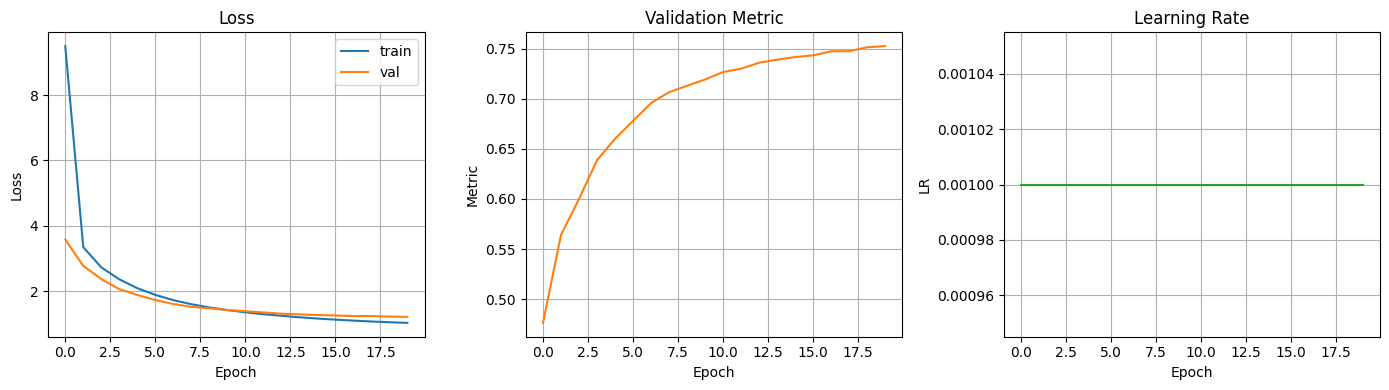

In [22]:
from src.utils import plot_training_logs

plot_training_logs(train_logs)

## 3.Inference

In [1]:
import torch
import torch.nn as nn

@torch.no_grad()
def greedy_decode(model, src_ids, pad_id, bos_id, eos_id, max_len, device):
    """
    Greedy decoding for Transformer model: computes encoder memory once, then
    iteratively generates target tokens using prior decoder outputs and memory.
    Supports batched inference, stops at EOS or max_len, and builds its own
    padding and causal masks.
    """
    batch_size = src_ids.size(0)
    model.eval()
    src_ids = src_ids.to(device)
    src_key_padding_mask = (src_ids == pad_id).to(device) # (N, S)

    # compute encoder memory
    src_emb = model.positional_embedding(model.shared_embedding(src_ids)) # (N, S, E)
    memory = model.transformer.encoder(src = src_emb,
                                       src_key_padding_mask = src_key_padding_mask) # (N, S, E)

    # prepare initial decoder input
    current_tokens = torch.full((batch_size, 1), bos_id, dtype=torch.long).to(device) # (N, 1)
    finished = torch.zeros(batch_size, dtype=torch.bool).to(device)
    outputs = [[] for _ in range(batch_size)]

    # decoding
    for step in range(max_len):
        # target embedding & masks (causal/padding)
        tgt_emb = model.positional_embedding(model.shared_embedding(current_tokens)).to(device) # (N, L, E)
        tgt_key_padding_mask = (current_tokens == pad_id).to(device) # usually false (N ,L)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(tgt_emb.size(1), dtype=torch.bool).to(device) # (L, L)

        # decoder outputs
        decoder_outputs = model.transformer.decoder(tgt = tgt_emb, memory = memory, tgt_mask = causal_mask, 
                                                    tgt_key_padding_mask = tgt_key_padding_mask,
                                                    memory_key_padding_mask = src_key_padding_mask) # (N, L, E)

        next_logits = model.output(decoder_outputs)[:, -1, :] # (N, vocab_size)
        next_tokens = next_logits.argmax(dim=-1) # (N,)

        # update current decoded tokens
        current_tokens = torch.cat([current_tokens, next_tokens.unsqueeze(1)], dim=1) # (N, L+1)

        # store output tokens & stop if EOS token found
        for i in range(batch_size):
            if not finished[i]:
                outputs[i].append(int(next_tokens[i].item()))
                if next_tokens[i] == eos_id:
                    finished[i] = True

        if finished.all():
            break

    return outputs

In [2]:
def translate(model, tokenizer, src_list, max_len=64, device=None):
    """
    args:
        src_list (List[str]): Source sentences to translate.
        max_len (int): maximum length of generated output sequence.
        device (torch.device, optional)
    returns:
        List[str]: translated target sentences.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    pad_id, bos_id, eos_id = [tokenizer.token_to_id(i) for i in ["[PAD]", "[BOS]", "[EOS]"]]    
    src_ids = torch.tensor([enc.ids for enc in tokenizer.encode_batch(src_list)],
                               dtype=torch.long) # (N, S)

    outputs = greedy_decode(model, src_ids, pad_id, bos_id, eos_id, max_len, device)
    return tokenizer.decode_batch(outputs)

In [3]:
import torch, tokenizers
from src.model import TransformerNMT
from src.config import HPARAMS

def load_model_and_tokenizer(tokenizer_path, model_checkpoint_path, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Torch Device: {device}")
    hp = HPARAMS()

    try:
        tokenizer = tokenizers.Tokenizer.from_file(tokenizer_path)
        tokenizer.enable_truncation(hp.max_seq_len)
        tokenizer.enable_padding(pad_id = 0, pad_token = "[PAD]")
        
        model = TransformerNMT(tokenizer.get_vocab_size(), hp.max_seq_len, **hp.model_hparams).to(device)
        state_dict = torch.load(model_checkpoint_path, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)
        return model, tokenizer
    except Exception as e:
        print(f"Error loading model/tokenizer: {e}")
        return None, None

model, tokenizer = load_model_and_tokenizer(tokenizer_path = "tokenizer/bpe_tokenizer.json",
                                            model_checkpoint_path = "model/transformer_nmt_model_params.pt")

Torch Device: cpu


In [4]:
%%time
eng_texts = ["yes! i built a translator!" ,
             "hello, darkness my old friend." ,
             "the capital of France is Paris, often called the city of light. It is famous for its history, architecture and vibrant culture.",
             "I was amazed by how the Japanese people built this many years ago. It is truly astonishing!"]

if model and tokenizer:
    es_trns = translate(model, tokenizer, eng_texts, max_len=64, device=None)
    for i in range(4):
        print(f"English Sentence: {eng_texts[i]}\nSpanish Translation: {es_trns[i]}")
        print("="*15)

English Sentence: yes! i built a translator!
Spanish Translation: ¡ sí ! ¡ yo construyó un traductor !
English Sentence: hello, darkness my old friend.
Spanish Translation: hola , oscuridad , mi viejo amigo .
English Sentence: the capital of France is Paris, often called the city of light. It is famous for its history, architecture and vibrant culture.
Spanish Translation: la capital de francia es parís , a menudo llamado la ciudad de la luz . es famosa por su historia , arquitectura y vi br ant án .
English Sentence: I was amazed by how the Japanese people built this many years ago. It is truly astonishing!
Spanish Translation: ¡ me asomb roso por cómo construyó los japoneses hace muchos años ! es realmente asomb roso .
CPU times: user 6.35 s, sys: 78.6 ms, total: 6.43 s
Wall time: 1.25 s
